In [1]:
import csv
import re
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.options.mode.chained_assignment = None
from datetime import datetime
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation
from collections import Counter

# Import Data

In [4]:
trainDF = pd.read_csv('data/training/data_train.csv', header=None)
trainDF.columns = ['country', 'sku_id' , 'title', 'category_lvl_1', 'category_lvl_2', 'category_lvl_3', 'short_description', 'price', 'product_type']

trainDF.head()

country              sku_id  \
0      my    AD674FAASTLXANMY   
1      my  AE068HBAA3RPRDANMY   
2      my  AN680ELAA9VN57ANMY   
3      my  AN957HBAAAHDF4ANMY   
4      my    AR511HBAXNWAANMY   

                                               title  \
0       Adana Gallery Suri Square Hijab – Light Pink   
1  Cuba Heartbreaker Eau De Parfum Spray 100ml/3.3oz   
2  Andoer 150cm Cellphone Smartphone Mini Dual-He...   
3  ANMYNA Complaint Silky Set 柔顺洗发配套 (Shampoo 520...   
4  Argital Argiltubo Green Clay For Face and Body...   

                          category_lvl_1 category_lvl_2  \
0                                Fashion          Women   
1                        Health & Beauty    Bath & Body   
2  TV, Audio / Video, Gaming & Wearables          Audio   
3                        Health & Beauty      Hair Care   
4                        Health & Beauty     Men's Care   

            category_lvl_3                                  short_description  \
0              Muslim Wear  <ul><li>Material : Non sheer shimmer chiffon</...   
1         Hand & Foot Care  Formulated with oil-free hydrating botanicals/...   
2       Live Sound & Stage  <ul> <li>150cm mini microphone compatible for ...   
3  Shampoos & Conditioners  <ul> <li>ANMYNA Complaint Silky Set (Shampoo 5...   
4       Body and Skin Care  <ul> <li>100% Authentic</li> <li>Rrefresh and ...   

    price   product_type  
0   49.00          local  
1  128.00  international  
2   25.07  international  
3  118.00          local  
4  114.80  international

In [5]:
# Look at how much data we have
trainDF.shape

(36283, 9)

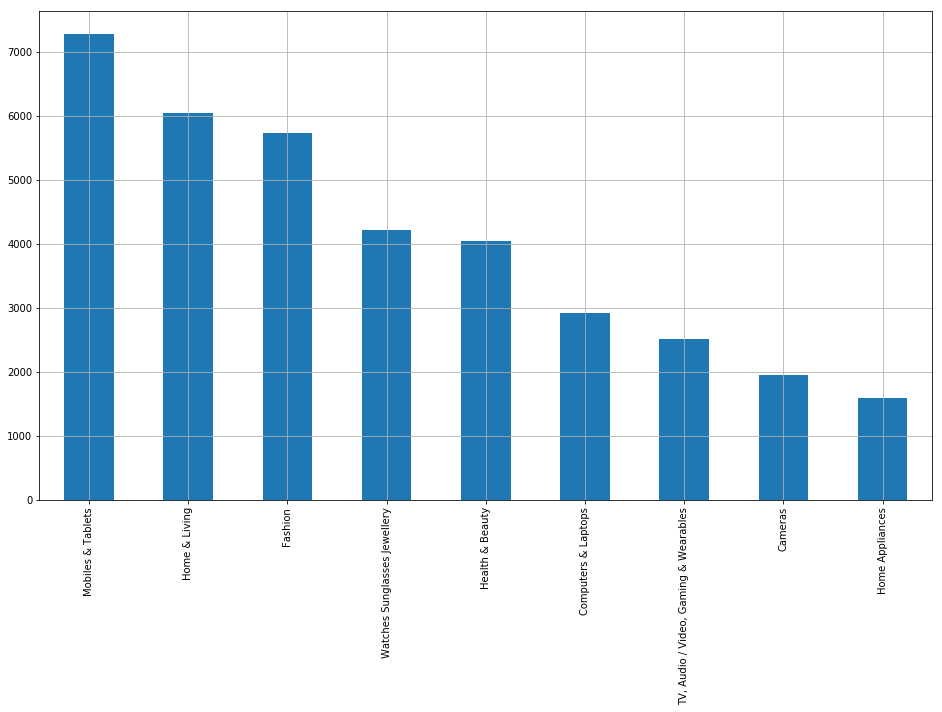

In [6]:
# Check distribution of level 1 category across dataset
trainDF.category_lvl_1.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

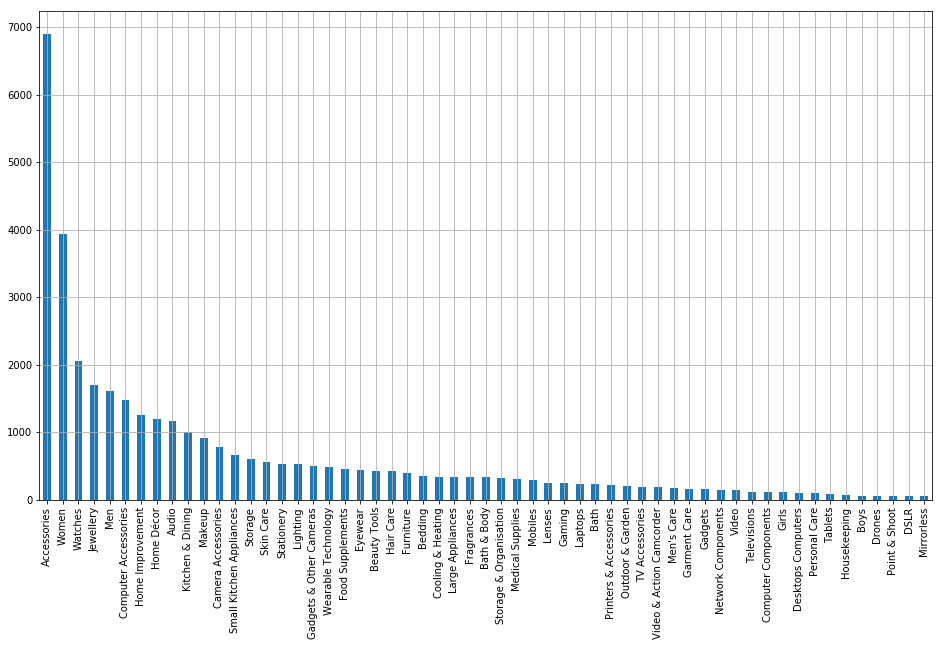

In [7]:
# Check distribution of level 2 category across dataset
trainDF.category_lvl_2.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

In [3]:
# Tokenizer function
def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', 
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)


In [8]:
# Call clean() function to clean and tokenize titles on the entire dataset
# Create new column called 'tokens' containing cleaned tokens.
trainDF['titleTokens'] = trainDF['title'].map(tokenizer)

In [9]:
# Check tokenization for first 5 listings
for title, tokens in zip(trainDF['title'].head(5), trainDF['titleTokens'].head(5)):
    print('title:', title)
    print('tokens:', tokens)
    print() 

title: Adana Gallery Suri Square Hijab – Light Pink
tokens: ['adana', 'gallery', 'suri', 'square', 'hijab', 'light', 'pink']

title: Cuba Heartbreaker Eau De Parfum Spray 100ml/3.3oz
tokens: ['cuba', 'heartbreaker', 'eau', 'de', 'parfum', 'spray', '100ml/3.3oz']

title: Andoer 150cm Cellphone Smartphone Mini Dual-Headed Omni-Directional Mic Microphone with Collar Clip for iPad iPhone5 6s 6 Plus Smartphones
tokens: ['andoer', '150cm', 'cellphone', 'smartphone', 'mini', 'dual-headed', 'omni-directional', 'mic', 'microphone', 'collar', 'clip', 'ipad', 'iphone5', '6s', 'plus', 'smartphones']

title: ANMYNA Complaint Silky Set 柔顺洗发配套 (Shampoo 520ml + Conditioner 250ml)
tokens: ['anmyna', 'complaint', 'silky', 'set', 'shampoo', '520ml', 'conditioner', '250ml']

title: Argital Argiltubo Green Clay For Face and Body 250ml
tokens: ['argital', 'argiltubo', 'green', 'clay', 'face', 'body', '250ml']



In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vectors = vectorizer.fit_transform(list(trainDF['title']))

Vectors is a TF-IDF matrix.
Number of rows is the total number of documents (descriptions)
Number of columns is the total number of unique terms (tokens) across the documents (descriptions)

$x_{dt} = tfidf(t,d)$ where $x_{dt}$ is the element at the index (d,t) in the matrix.

In [11]:
vectors.shape

(36283, 7025)

Create a dictionary mapping the tokens to their tfidf values

In [12]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Create a histogram to visualize distribution of the TF-IDF scores

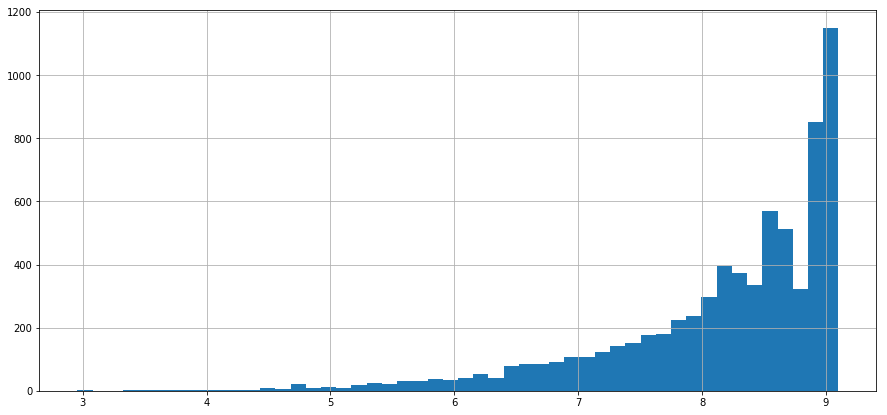

In [13]:
tfidf.tfidf.hist(bins=50, figsize=(15,7))

In [14]:
labels = np.loadtxt("data/training/conciseness_train.labels", dtype=int)

trainDF['labels'] = labels

In [15]:
tfidf

tfidf
spotlight          7.972772
toaster            7.627931
corner             8.860075
fat                7.456081
artist             9.014226
19.5v              7.915613
remote controller  7.888214
12mm               8.503400
light blue         6.999322
plus               4.662873
f1s                8.554693
relogio masculino  8.860075
essential          6.893962
gas                7.421595
220v               7.404788
j5                 7.250637
cleaning brush     8.934183
carry case         8.860075
bangles            8.503400
jewelry 18k        9.014226
3d wall            8.726543
xzy                8.934183
cover pouch        8.934183
silky              8.860075
shell apple        9.014226
acne               7.972772
candle             7.473780
fashion high       8.503400
pasta              8.934183
knitted            7.092413
...                     ...
nokia              6.720009
stand wallet       7.491799
frame mirror       8.454610
acrylic            6.686948
points             8.791082
laserjet           8.934183
mens fashion       9.014226
sticker home       8.203295
jor                7.587109
baellerry          9.014226
density            8.665919
wigs               8.363638
superwoman         8.280256
murals             8.934183
foam bath          9.014226
sport wrist        8.608760
short sleeve       6.152025
xperia z4          8.503400
korean             5.795350
versace            9.101237
silica             8.166928
case iphone7       8.860075
original box       8.934183
sos                8.860075
pomade             8.554693
swimsuit           7.155327
floating           7.943784
diode              8.454610
winter women       9.101237
curve              8.860075

[7025 rows x 1 columns]

In [16]:
# First use TruncatedSVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vectors)

In [17]:
svd_tfidf.shape

(36283, 50)

In [18]:
# Now try to reduce dimensionality even further with T-SNE
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=2, random_state=0, n_iter_without_progress = 300)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 36283
[t-SNE] Computed conditional probabilities for sample 2000 / 36283
[t-SNE] Computed conditional probabilities for sample 3000 / 36283
[t-SNE] Computed conditional probabilities for sample 4000 / 36283
[t-SNE] Computed conditional probabilities for sample 5000 / 36283
[t-SNE] Computed conditional probabilities for sample 6000 / 36283
[t-SNE] Computed conditional probabilities for sample 7000 / 36283
[t-SNE] Computed conditional probabilities for sample 8000 / 36283
[t-SNE] Computed conditional probabilities for sample 9000 / 36283
[t-SNE] Computed conditional probabilities for sample 10000 / 36283
[t-SNE] Computed conditional probabilities for sample 11000 / 36283
[t-SNE] Computed conditional probabilities for sample 12000 / 36283
[t-SNE] Computed conditional probabilities for sample 13000 / 36283
[t-SNE] Computed conditional probabilities 

In [19]:
# Check how many dimensions 
tsne_tfidf.shape

(36283, 2)

In [21]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

output_notebook()
colormap = np.array(["#6d8dca", "#69de53"])
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf plot of titles",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [23]:
# Visualizing all the articles in 2-d space
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['labels'] = trainDF['labels']
tfidf_df['title'] = trainDF['title']
plot_tfidf.scatter(x='x', y='y', color=colormap[tfidf_df['labels']], source=tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"title": "@title", "labels":"@labels"}
show(plot_tfidf)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


In [27]:
tfidf.index

Index(['spotlight', 'toaster', 'corner', 'fat', 'artist', '19.5v',
       'remote controller', '12mm', 'light blue', 'plus',
       ...
       'silica', 'case iphone7', 'original box', 'sos', 'pomade', 'swimsuit',
       'floating', 'diode', 'winter women', 'curve'],
      dtype='object', length=7025)

In [51]:
def keyword_density(title):
    count = 0
    length = len(title)
    for word in title:
        if word in tfidf.index:
            count += 1
    density = count/length if count>1 else 0
    return density

In [52]:
trainDF['titleKeywordDensity'] = trainDF['titleTokens'].map(keyword_density)

In [56]:
trainDF['titleKeywordDensity'].head()

0    0.571429
1    0.714286
2    0.750000
3    0.625000
4    0.714286
Name: titleKeywordDensity, dtype: float64

In [57]:
trainDF['titleLength'] = trainDF['titleTokens'].map(len)
trainDF['titleLength'].head()

0     7
1     7
2    16
3     8
4     7
Name: titleLength, dtype: int64

In [55]:
trainDF

country               sku_id  \
0          my     AD674FAASTLXANMY   
1          my   AE068HBAA3RPRDANMY   
2          my   AN680ELAA9VN57ANMY   
3          my   AN957HBAAAHDF4ANMY   
4          my     AR511HBAXNWAANMY   
5          my     AS575ELCMZ4WANMY   
6          my   AS727ELAA9LLV1ANMY   
7          my   BU512HBAA4WUVTANMY   
8          my     CL787ELAW29LANMY   
9          my   CO633HLAABREKOANMY   
10         my   EL802HLAA51ZZVANMY   
11         my   EM688OTAA9H8S8ANMY   
12         my   FE090OTAAAPW6VANMY   
13         my   FI087ELAA7Z6D7ANMY   
14         my     FO862HBAZ6LWANMY   
15         my   HA543FAAAA8IHWANMY   
16         my   JI013OTAA5FMEDANMY   
17         my   JI733ELAA3XWA1ANMY   
18         my   JO156ELAA6CO0MANMY   
19         my   JO511HBAA7CGMGANMY   
20         my     JU816FAAPKMIANMY   
21         my   KD209HAAAA8EEEANMY   
22         my   KE294HLAA8EBUZANMY   
23         my   KO422HBAA8WEQ8ANMY   
24         my     LE106ELAVO5SANMY   
25         my   LU316ELAA8O9BQANMY   
26         my     LY834FABEWC9ANMY   
27         my   MO158HAAA30BBCANMY   
28         my     MO554ELBMC5YANMY   
29         my     MO554ELCHBVMANMY   
...       ...                  ...   
36253      sg  NO780ELAA30ZYYSGAMZ   
36254      sg  NO780ELAA486CNSGAMZ   
36255      sg  NO780ELAA4MLZ4SGAMZ   
36256      sg    NO780ELBO5LASGAMZ   
36257      sg  NO780FAAA1M7G5SGAMZ   
36258      sg  NO780HLAA20RXVSGAMZ   
36259      sg  NO780HLAA3EG41SGAMZ   
36260      sg  NO780OTAA2MX2XSGAMZ   
36261      sg  NO780OTAA303CPSGAMZ   
36262      sg  NO780OTAA4YOAJSGAMZ   
36263      sg  OE702ELAA5250RSGAMZ   
36264      sg  OE702ELAA69DEFSGAMZ   
36265      sg  OE702ELAA6E3SISGAMZ   
36266      sg  OE702ELAA6X0TPSGAMZ   
36267      sg  OE702FAAA1HHG4SGAMZ   
36268      sg  OE702FAAA5AEBWSGAMZ   
36269      sg  OE702FAAA5Z72NSGAMZ   
36270      sg  OE702FAAA7A987SGAMZ   
36271      sg  OE702HBAA410VXSGAMZ   
36272      sg  OE702HLAA62CRBSGAMZ   
36273      sg  OE702HLAA6A43ISGAMZ   
36274      sg  OE702HLAA89KUZSGAMZ   
36275      sg  OE702OTAA6V6FXSGAMZ   
36276      sg  PH272HAAA5B4LKSGAMZ   
36277      sg  PH272HBAA4UPWOSGAMZ   
36278      sg  SA584ELAA4G4W0SGAMZ   
36279      sg  SO499HAAA4CCLASGAMZ   
36280      sg  TI990ELAA5ZV1JSGAMZ   
36281      sg  WO203HLAA3KFPCSGAMZ   
36282      sg  ZO445ELAA848V9SGAMZ   

                                                   title  \
0           Adana Gallery Suri Square Hijab – Light Pink   
1      Cuba Heartbreaker Eau De Parfum Spray 100ml/3.3oz   
2      Andoer 150cm Cellphone Smartphone Mini Dual-He...   
3      ANMYNA Complaint Silky Set 柔顺洗发配套 (Shampoo 520...   
4      Argital Argiltubo Green Clay For Face and Body...   
5      Asus TP300LJ-DW004H Transformer Book Flip 4GB ...   
6      NG-40C Ring-Shaped 40W 3166lm 5400K Macro Phot...   
7                Buytra Exfoliating Peel Foot Mask 1Pair   
8      CLiPtec OCC121 Slim Flat USB 3.0 Extension Cab...   
9      McDonald's Coke Can Glass Limited Edition 12oz...   
10     ELENXS Stainless Steel Tea Ball Strainer Mesh ...   
11          7mm Natural Prehnite Crystal Bracelet(Green)   
12     Feelontop Punk Rock Rhinestone Star Shape Long...   
13     Fitbit Charge Wireless Activity Wristband, Blu...   
14               Foltene Eyelash &amp; Eyebrow Treatment   
15     Hanyu Men PU Leather Lace Up Cap-Toe Business ...   
16     JinGle Winner Mens women Skeleton Rose Gold St...   
17     JIANSE Cranes Sky Flight Couple Cloud Hard Bac...   
18     joyliveCY Universal Lazy Android Mobile Phone ...   
19     Joop Le Bain Soft Moments Eau De Parfum Spray ...   
20        Juju Milky Emerald Eye Rhinestone Cheetah Stud   
21     Kdk 16" Wall Fan (Remote) &nbsp;Oscillation Co...   
22     DIY Marble Contact Paper PVC Removable Wallpap...   
23     5 units of Korea Soothing &amp; Moisture 99% A...   
24                          Lenovo Battery BL203 1500mAH   
25     LUOWAN Galaxy S7 Edge Case - Silicone Soft TPU...   
26     Prado2u LYY Korean Can

In [25]:
def contains_number(s):
    regex = re.compile("\d")
    if regex.search(s):
        return True
    return False

def extract_features(filename):
    features = []
    with open(filename, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            title = row[2]
            ''' 
                Feel free to create your amazing features here
                ...
            '''
            features.append([len(title), contains_number(title)])
    return np.asarray(features)

def write_submission(filename, predicted_results):
    if not os.path.exists('submission'):
        os.makedirs('submission')
    np.savetxt('submission/' + filename, predicted_results, fmt='%.5f')
    print(filename + ' updated!')

# Predict Conciseness

In [ ]:
# Data loading
X = extract_features("data/training/data_train.csv")
y = np.loadtxt("data/training/conciseness_train.labels", dtype=int)

# Model training
model = LogisticRegression()
model.fit(X, y)
print("Model RMSE: %f" % mean_squared_error(model.predict_proba(X)[:,1], y)**0.5)

# Validation predicting
X_valid = extract_features("data/validation/data_valid.csv")
predicted_results = model.predict_proba(X_valid)[:, 1]
write_submission('conciseness_valid.predict', predicted_results)

# Predict Clarity

In [ ]:
# Data loading
X = extract_features("data/training/data_train.csv")
y = np.loadtxt("data/training/clarity_train.labels", dtype=int)

# Model training
model = LogisticRegression()
model.fit(X, y)
print("Model RMSE: %f" % mean_squared_error(model.predict_proba(X)[:,1], y)**0.5)

# Validation predicting
X_valid = extract_features("data/validation/data_valid.csv")
predicted_results = model.predict_proba(X_valid)[:, 1]
write_submission('clarity_valid.predict', predicted_results)

# Test Code

In [ ]:
os.system('zip -j submission submission/*')